In [69]:
using BALUtils
using SparseArrays
using Glob
using DataFrames
using RCall
@rlibrary ggplot2

In [14]:
function implicit_cost(ba :: BA) 
    #F'F - F'E inv(E'E) E'F
    mulcost = 9 * num_observations(ba) * 2 * 4 + # 4 multiplies with F (xy for each observation)
              3 * num_observations(ba) * 2 * 2 + # 2 multiplies with E
              num_cameras(ba) * 9 + # the substraction
              3 * num_observations(ba) * 2 * 3 + # E'E
              num_points(ba) * 3 * 3 * 3 + # inv
              num_points(ba) * 3* 3 # application of inv(E'E)
    vecsize = 9 * num_cameras(ba) + 3 * num_points(ba)
    mulcost, vecsize
end

function implicit_pbjacobi(ba :: BA)
    # switch visibility graph from camera->points to point->cameras
    pvis = map(x -> Vector{Tuple{Int,Float64,Float64}}(), 1:num_points(ba))
    for (ic, obs) in enumerate(ba.observations)
        for (ip, x, y) in obs
            push!(pvis[ip], (ic, x, y))
        end
    end
    
    setup =
    sum(map(c -> length(c) * (9 * 2 * 3 + # F'E
                              3 * 3 * 9 + # inv(E'E) * E'F
                              9 * 3 * 9 + # F'E * inv(E'E) * E'F
                              9 * 9 # summation
                ), pvis)) +
    num_cameras(ba) * 9 * 9^2 # inv
    mul = num_cameras(ba) * 9 * 9
    setup, mul
end

implicit_pbjacobi (generic function with 1 method)

In [41]:
function explicit_cost(ba :: BA)
    # switch visibility graph from camera->points to point->cameras
    pvis = map(x -> Vector{Tuple{Int,Float64,Float64}}(), 1:num_points(ba))
    for (ic, obs) in enumerate(ba.observations)
        for (ip, x, y) in obs
            push!(pvis[ip], (ic, x, y))
        end
    end
    
    # TODO: add nash-sofer criteria
    setupcost =
    9 * num_observations(ba) * 2 * 9 + # block diagonal F'F
    3 * num_observations(ba) * 2 * 3 + # block diagonal E'E
    3 * num_points(ba) * 3^2 + # inv
    3 * num_points(ba) * 3 + # inv(E'E) * b
    sum(map(c -> 9*2*3*length(c)^2 + # F'E for each chunk entry
                 length(c)^2 * (3*3*9 + # inv(E'E) * E'F
                                9*3*9 + # F'E * (inv(E'E) * E'F)
                                9*9 # summation over all blocks
                                ) +
                 length(c) * (9 * 3 + 9 * 3) + # rhs F'E * b
                 length(c) * (9 * 2 + 3 * 2 + 3) # back substitute
             , pvis)) +
    3 * num_points(ba) * 3 # inv(E'E) * x for backsubstitute
    mulcost = nnz(visibility_graph(ba)) * 9 * 9
    vecsize = num_cameras(ba) * 9
    setupcost, mulcost, vecsize
end

function explicit_pbjacobi(ba :: BA)
    setup = num_cameras(ba) * 9 * 9^2 # inv
    mul = num_cameras(ba) * 9 * 9
    setup, mul
end

explicit_pbjacobi (generic function with 2 methods)

In [34]:
function break_even_matmul(ba)
    im, _ = implicit_cost(ba)
    ex_setup, ex_mul, _ = explicit_cost(ba)
    if (ex_mul - im) > 0
        Inf
    else
        - ex_setup / (ex_mul - im)
    end
end

function break_even_cg(ba)
    # TODO pbjacobi creation cost
    im_mul, imvec = implicit_cost(ba)
    im_setup, impbjacobi_mul = implicit_pbjacobi(ba)
    im_mul += impbjacobi_mul
    ex_setup, ex_mul, exvec = explicit_cost(ba)
    expbjacobi_setup, expbjacobi_mul = explicit_pbjacobi(ba)
    ex_setup += expbjacobi_setup
    ex_mul += expbjacobi_mul
    
    diff_setup = im_setup - ex_setup
    diff_solve = (ex_mul + exvec * 3 + exvec * 2) - (im_mul + imvec * 3 + imvec * 3)
    if diff_solve > 0 && diff_setup < 0
        Inf
    else
      diff_setup / diff_solve
    end
end

break_even_cg (generic function with 1 method)

In [35]:
ba = readbal("../ba-problems/5K_2K_10.problem/problem_noised.bbal")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = Inf
break_even_cg(ba) = Inf


Inf

In [36]:
ba = readbal("../ba-problems/bal-ladybug-1723.problem/problem_noised.bbal")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = 59.63571759147212
break_even_cg(ba) = 51.42126843311785


51.42126843311785

In [37]:
ba = readbal("../ba-problems/bal-ladybug-49.problem/problem.bbal")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = 31.80014545636042
break_even_cg(ba) = 26.358340983701932


26.358340983701932

In [38]:
ba = readbal("../bal-data/final/problem-3068-310854-pre.txt")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = 1400.7548950714292
break_even_cg(ba) = 1056.1088317288604


1056.1088317288604

In [39]:
ba = readbal("../bal-data/trafalgar/problem-257-65132-pre.txt")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = 30.403870689987695
break_even_cg(ba) = 24.89042060668174


24.89042060668174

In [40]:
ba = readbal("../bal-data/venice/problem-1778-993923-pre.txt")
@show break_even_matmul(ba)
@show break_even_cg(ba)

break_even_matmul(ba) = 71.57372876416945
break_even_cg(ba) = 64.71827537499925


64.71827537499925

In [116]:
df = map(glob("../bal-data/*/*.txt")) do f
    ba = readbal(f)
    DataFrame(problem=f, points=num_points(ba), cameras=num_cameras(ba), observations=num_observations(ba), fillin=(nnz(visibility_graph(ba))*9^2)/((num_cameras(ba)*9)^2), matmul=break_even_matmul(ba), cg=break_even_cg(ba))
end |> x -> vcat(x...)

,problem,points,cameras,observations
,String,Int64,Int64,Int64
1,../bal-data/dubrovnik/problem-16-22106-pre.txt,22106,16,83718
2,../bal-data/dubrovnik/problem-356-226730-pre.txt,226730,356,1255268
3,../bal-data/final/problem-13682-4456117-pre.txt,4456117,13682,28987644
4,../bal-data/final/problem-3068-310854-pre.txt,310854,3068,1653812
5,../bal-data/ladybug/problem-1723-156502-pre.txt,156502,1723,678718
6,../bal-data/ladybug/problem-49-7776-pre.txt,7776,49,31843
7,../bal-data/trafalgar/problem-21-11315-pre.txt,11315,21,36455
8,../bal-data/trafalgar/problem-257-65132-pre.txt,65132,257,225911
9,../bal-data/venice/problem-1102-780462-pre.txt,780462,1102,4052340


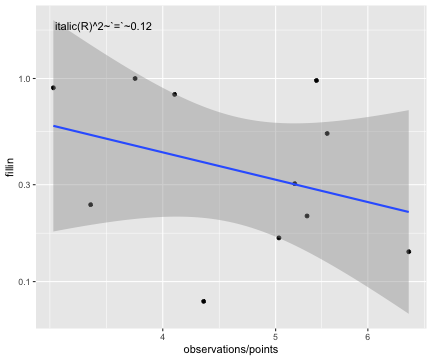

RObject{VecSxp}


In [127]:
R"library(ggplot2);library(ggpmisc)"
R"ggplot($df, aes(x=observations/points, y=fillin)) + geom_point() + scale_x_log10() + scale_y_log10() + geom_smooth(method = \"lm\") + stat_poly_eq(formula=y ~ x)"